<a href="https://colab.research.google.com/github/titusss/PixelAlchemist/blob/main/PixelAlchemist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🎛️🎚️ Pixel Alchemist
### Generative semantic image editing in realtime with a multi-parameter interface for StyleCLIP global directions
Instructions: As long as you have a GPU runtime from Google Colab, you should be able to simply run all cells via ```Runtime > Run all```. A P100 GPU is ideal. Follow instructions in the web interface for a ngrok authtoken.

The whole notebook will need about 5-10 minutes to initialize.

In [1]:
#@title
# Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU. To enable a GPU, go to Runtime > Change runtime type.')
else:
  print(gpu_info)

Thu May 19 06:33:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. **StyleCLIP Global Directions**

In [2]:
#@title StyleCLIP Setup.
#@markdown ETA: 3-5 minutes

%tensorflow_version 1.x
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

!pip install pyngrok
!pip install flask-ngrok
!pip install flask==0.12.2

% cd
% cd /content/

!pip install ftfy regex tqdm 
!pip install git+https://github.com/openai/CLIP.git 
!git clone https://github.com/orpatashnik/StyleCLIP

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

%load_ext autoreload
%autoreload 2

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.2 MB/s eta 0:04:29tcmalloc: large alloc 1147494400 bytes == 0x396a8000 @  0x7f0c50e77615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:25tcmalloc: large alloc 1434370048 bytes == 0x7dcfe000 @  0x7f0c50e77615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 1156.7 MB 1.2 MB/s eta 0:00:01tcmalloc: large

In [3]:
#@title Download datasets from Google Drive
#@markdown ETA: 1-3 minutes
import gdown
from gdown import download as drive_download

# name: The name of your dataset. Your .pkl model has to have the same name.
# npy: A Google Drive link to a folder containing the S, W, S_mean_std, and fs3 files from StyleCLIP's pre-processing. See here for pre-processing instructions: https://github.com/orpatashnik/StyleCLIP#user-content-usage-2
# neutral: A generic neutral prompt describing a picture that the model will likely generate.
# (Optional) default_targets: A list of target prompts that are known to work well.

datasets = {
    'posters': {'name': 'posters',
     'npy': 'https://drive.google.com/drive/folders/1cwv9SsPtv2abOM47Mb7L7Xk4iyNbwndf',
     'pkl': 'https://drive.google.com/uc?id=1eaqnnqnzhPGdTXGMzSAd8YifMuooF0Qd',
     'neutral': 'A colorful modern artwork',
     'default_targets': ['Simple', 'Dynamic', 'Punk Rock', 'Colorful']
     },
    'animals': {'name': 'animals',
     'npy': 'https://drive.google.com/drive/folders/10x9lqgHoU0OQIdQfZKRPDr2HI0b1s1U_',
     'pkl': 'https://drive.google.com/uc?id=1-qHksCZp_2yUf011ZasZqBdlwGZpnagT',
     'neutral': 'An animal'
    },
    'ffhq': {'name': 'ffhq',
     'npy': 'https://drive.google.com/drive/folders/1o7UCj8LthlT66Jf00fPwvZ41JJtv8Svv',
     'pkl': 'https://drive.google.com/uc?id=16oVGBwnasGz6g9-gSx4xlAJnW8M6evIg',
     'neutral': 'A face with eyes',
     'default_targets': ['Taylor Swift', 'Long hair', 'Glasses', 'Blue eyes', 'Elon Musk', 'Sad', 'A smiling face', 'Surprised', 'Lipstick', 'Red hair']
     },
    'churches': {'name': 'churches',
     'npy': 'https://drive.google.com/drive/folders/1xKMAsJvI4WzNTUWCkTZcUdasn6XbqIx_',
     'pkl': 'https://drive.google.com/uc?id=1hZFGANpBYnuU6TtgAEM81b5i2xHiREnL',
     'neutral': 'A church building',
     'default_targets': ['Big church', 'Trees', 'Clouds', 'A building made of red bricks', 'Foggy weather']
     },
     'cars': {'name': 'cars',
      'npy': 'https://drive.google.com/drive/folders/1FBSeIWSDNC7dzXKLr4jPF1AIUxjLzHv7',
      'pkl': 'https://drive.google.com/uc?id=1NHmT5yMiN7KAdEUOo2ek8Hje5gtc-TVz',
      'neutral': 'Car',
      'default_targets': ['Van', 'Sports Car', 'Big wheels', 'Rain', 'BMW', 'A blue car', 'A car from tge 60s', 'Blue car']
     }
}

% cd
% cd /content/StyleCLIP/global_directions/npy

for d in datasets:
  print('Downloading StyleCLIP .npy files for:', d)
  gdown.download_folder(url=datasets[d]['npy'])

% cd
% cd /content/StyleCLIP/global_directions/model

for d in datasets:
  print('Downloading .pkl files for:', d)
  gdown.download(url=datasets[d]['pkl'])

/root
/content/StyleCLIP/global_directions/npy


Retrieving folder list


Processing file 1Lz_gCUE2NSYSL7bkV-iKXtfm8LAsZ4RJ fs3.npy
Processing file 1p8Vvosm075fvnuGBu5R--vbIRMtNeNlX S
Processing file 1UgrWs9pjCyXN5fQp12reu6zaYrS_cI3O S_mean_std
Processing file 1WKYjxtNCZ9TOI5zGV578Xf4LltHnPa-1 W.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1Lz_gCUE2NSYSL7bkV-iKXtfm8LAsZ4RJ
To: /content/StyleCLIP/global_directions/npy/posters/fs3.npy
100%|██████████| 5.51M/5.51M [00:00<00:00, 24.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1p8Vvosm075fvnuGBu5R--vbIRMtNeNlX
To: /content/StyleCLIP/global_directions/npy/posters/S
100%|██████████| 71.7M/71.7M [00:01<00:00, 47.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UgrWs9pjCyXN5fQp12reu6zaYrS_cI3O
To: /content/StyleCLIP/global_directions/npy/posters/S_mean_std
100%|██████████| 73.7k/73.7k [00:00<00:00, 24.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WKYjxtNCZ9TOI5zGV578Xf4LltHnPa-1
To: /content/StyleCLIP/global_directions/npy/posters/W.npy
100%|██████████| 58.4M/58.4M [00:00<00:00, 71.1MB/s]
Download completed
Retrieving folder list


Processing file 176RdP1KJWand9bNlw7dFR_FnHw6f6abx fs3.npy
Processing file 1i2oI4tRr5vLllaDhLBgW0mlHnuOaWnKQ S
Processing file 1HmmrAjiu7o4Aq2PP0Vd1VmIrkYeR-8CJ S_mean_std
Processing file 1axB9ehfg2V12rVJGVS8lVL6zIZHQBXui W.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=176RdP1KJWand9bNlw7dFR_FnHw6f6abx
To: /content/StyleCLIP/global_directions/npy/animals/fs3.npy
100%|██████████| 5.51M/5.51M [00:00<00:00, 29.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1i2oI4tRr5vLllaDhLBgW0mlHnuOaWnKQ
To: /content/StyleCLIP/global_directions/npy/animals/S
100%|██████████| 71.7M/71.7M [00:01<00:00, 49.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HmmrAjiu7o4Aq2PP0Vd1VmIrkYeR-8CJ
To: /content/StyleCLIP/global_directions/npy/animals/S_mean_std
100%|██████████| 73.7k/73.7k [00:00<00:00, 48.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1axB9ehfg2V12rVJGVS8lVL6zIZHQBXui
To: /content/StyleCLIP/global_directions/npy/animals/W.npy
100%|██████████| 205M/205M [00:02<00:00, 89.2MB/s]
Download completed
Retrieving folder list


Processing file 1VGVIhpQFEK8w7W_2KjHeT7UWX9unFuCv fs3.npy
Processing file 1lYAeo276SHEt0XwIt9tPqti7p2Fm3vEO S
Processing file 1FJP2-Z0rZhA6we15aDQIVuJBukp3PHEj S_mean_std
Processing file 1hCoolbV5cJqmyKO2jILG6RwgSma1Xtm- W.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1VGVIhpQFEK8w7W_2KjHeT7UWX9unFuCv
To: /content/StyleCLIP/global_directions/npy/ffhq/fs3.npy
100%|██████████| 6.19M/6.19M [00:00<00:00, 35.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lYAeo276SHEt0XwIt9tPqti7p2Fm3vEO
To: /content/StyleCLIP/global_directions/npy/ffhq/S
100%|██████████| 72.7M/72.7M [00:01<00:00, 42.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FJP2-Z0rZhA6we15aDQIVuJBukp3PHEj
To: /content/StyleCLIP/global_directions/npy/ffhq/S_mean_std
100%|██████████| 75.1k/75.1k [00:00<00:00, 18.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hCoolbV5cJqmyKO2jILG6RwgSma1Xtm-
To: /content/StyleCLIP/global_directions/npy/ffhq/W.npy
100%|██████████| 205M/205M [00:02<00:00, 83.2MB/s]
Download completed
Retrieving folder list


Processing file 1nSV2LB73S4u2lW7F_pNJzxvrchqCspLg fs3.npy
Processing file 1N8YyisWR4_ceWiPYH0qv2YeWGMTsW9PU S
Processing file 1lDmiL5M3hfHr8St7Ac_3TD5UMbUUWiFh S_mean_std
Processing file 1xgFWt7HP1SYw_q-GEeW85OmLxs2pdXuJ W.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1nSV2LB73S4u2lW7F_pNJzxvrchqCspLg
To: /content/StyleCLIP/global_directions/npy/churches/fs3.npy
100%|██████████| 5.51M/5.51M [00:00<00:00, 28.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N8YyisWR4_ceWiPYH0qv2YeWGMTsW9PU
To: /content/StyleCLIP/global_directions/npy/churches/S
100%|██████████| 69.6M/69.6M [00:01<00:00, 51.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lDmiL5M3hfHr8St7Ac_3TD5UMbUUWiFh
To: /content/StyleCLIP/global_directions/npy/churches/S_mean_std
100%|██████████| 71.4k/71.4k [00:00<00:00, 31.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xgFWt7HP1SYw_q-GEeW85OmLxs2pdXuJ
To: /content/StyleCLIP/global_directions/npy/churches/W.npy
100%|██████████| 205M/205M [00:02<00:00, 69.1MB/s]
Download completed
Retrieving folder list


Processing file 1iS1Z6LX21ipdAbeJVIAEodHWWki_3GLn fs3.npy
Processing file 1DZMYJiQNjkZ5hJsAgbWlJiGP6limdahu S
Processing file 1ejYxoT38uRKMMMWzflePTKGgI0_DVrFr S_mean_std
Processing file 1m9SgyYIveHAtR9a3C2bp3qaeEl6NeZ-l W.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1iS1Z6LX21ipdAbeJVIAEodHWWki_3GLn
To: /content/StyleCLIP/global_directions/npy/cars/fs3.npy
100%|██████████| 5.51M/5.51M [00:00<00:00, 39.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DZMYJiQNjkZ5hJsAgbWlJiGP6limdahu
To: /content/StyleCLIP/global_directions/npy/cars/S
100%|██████████| 71.7M/71.7M [00:01<00:00, 36.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ejYxoT38uRKMMMWzflePTKGgI0_DVrFr
To: /content/StyleCLIP/global_directions/npy/cars/S_mean_std
100%|██████████| 73.7k/73.7k [00:00<00:00, 68.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1m9SgyYIveHAtR9a3C2bp3qaeEl6NeZ-l
To: /content/StyleCLIP/global_directions/npy/cars/W.npy
100%|██████████| 205M/205M [00:03<00:00, 55.8MB/s]
Download completed


/root
/content/StyleCLIP/global_directions/model


Downloading...
From: https://drive.google.com/uc?id=1eaqnnqnzhPGdTXGMzSAd8YifMuooF0Qd
To: /content/StyleCLIP/global_directions/model/posters.pkl
100%|██████████| 364M/364M [00:05<00:00, 68.9MB/s]


Downloading...
From: https://drive.google.com/uc?id=1-qHksCZp_2yUf011ZasZqBdlwGZpnagT
To: /content/StyleCLIP/global_directions/model/animals.pkl
100%|██████████| 364M/364M [00:05<00:00, 61.8MB/s]


Downloading...
From: https://drive.google.com/uc?id=16oVGBwnasGz6g9-gSx4xlAJnW8M6evIg
To: /content/StyleCLIP/global_directions/model/ffhq.pkl
100%|██████████| 382M/382M [00:10<00:00, 35.3MB/s]


Downloading...
From: https://drive.google.com/uc?id=1hZFGANpBYnuU6TtgAEM81b5i2xHiREnL
To: /content/StyleCLIP/global_directions/model/churches.pkl
100%|██████████| 357M/357M [00:04<00:00, 87.5MB/s]


Downloading...
From: https://drive.google.com/uc?id=1NHmT5yMiN7KAdEUOo2ek8Hje5gtc-TVz
To: /content/StyleCLIP/global_directions/model/cars.pkl
100%|██████████| 364M/364M [00:03<00:00, 118MB/s] 


# Default values

Set the JPEG-compression of the generated image (0 worst, 100 best quality) based on your internet speed. A value around 70 is usually a good tradeoff. You can also enter the default dataset_name and image seed, as well as the default amount of parameteric sliders. The last three parameters can all be dynamically changed in the GUI.

In [4]:
image_quality = 75 #@param {type:'integer'} JPEG compression of each frame. Adjust this based on your internet speed.
parameter_amount = 3 #@param {type:'integer'} Amount of default parameters
dataset_name = 'churches' #@param [datasets] {allow-input: true} The default dataset name
img_index =  1994 #@param {type:'number'}

In [5]:
#@title Dataset setup helper function
% cd
% cd /content/StyleCLIP/global_directions/

import tensorflow as tf
import gc
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from global_directions.manipulate import Manipulator

def load_model(name, sess):
  print('Received session:', sess)
  if sess is not None:
    sess.close()
  tf.reset_default_graph()

  device = "cuda" if torch.cuda.is_available() else "cpu"
  model, preprocess = clip.load("ViT-B/32", device=device) 

  M=Manipulator(dataset_name=name)
  fs3=np.load('./npy/'+name+'/fs3.npy')
  np.set_printoptions(suppress=True)

  img_indexs=[img_index]
  dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
  M.num_images=len(img_indexs)

  M.alpha=[0]
  M.manipulate_layers=[0]
  codes,out=M.EditOneC(0,dlatent_tmp) 
  original=Image.fromarray(out[0,0]).resize((512,512))
  M.manipulate_layers=None

  active_dataset = {
      'M': M,
      'fs3': fs3,
      'dlatent_tmp': dlatent_tmp,
      'model': model,
      'original': original,
      'neutral': datasets[name]['neutral']
  }
  if 'default_targets' in datasets[name]:
    active_dataset['default_targets'] = datasets[name]['default_targets']
  
  return active_dataset

/root
/content/StyleCLIP/global_directions


Received session: None


100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 58.7MiB/s]


Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.

Gs                            Params    OutputShape         WeightShape     
---                           ---       ---                 ---             
latents_in                    -         (?, 512)            -               
labels_in                     -         (?, 0)              -               
lod                           -         ()                  -               
dlatent_avg                   -         (512,)              -               
G_mapping/Normalize           -         (?, 512)            -               
G_mapping/Dense0              262656    (?, 512)            (512, 512)      
G_mapping/Dense1              262656    (?, 512)            (512, 512)      
G_mapping/Dense2              262656    (?, 512)            (512, 512)      
G_mapping/Dense3              262656    (?, 512)            (512, 512)   

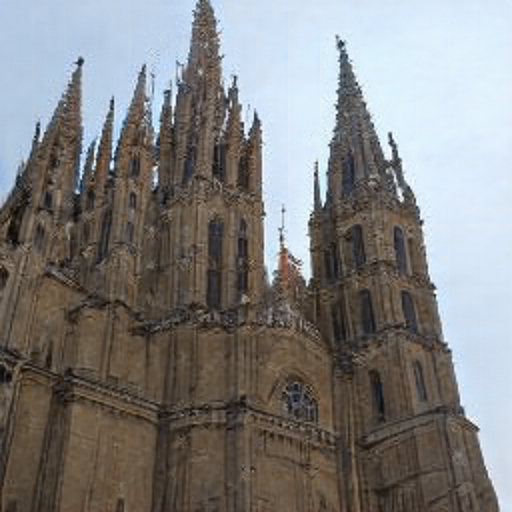

In [6]:
#@title Check output of active GAN model
#@markdown ETA: 1-3 minutes
active_dataset = load_model(dataset_name, None)
active_dataset['original']

In [7]:
#@title Helper functions and default setup
from io import BytesIO
from flask import send_file, make_response
import base64
import random

# Setup default values for sliders and text prompts
params = {}
dts = []
mul = np.multiply # Small speedup trick


def setup_parameter(index, target, dataset):
  global params
  global dts

  if target is None:
    if 'default_targets' in dataset:
      rti = random.randint(0, len(dataset['default_targets']) - 1) # Random default prompt
      target = dataset['default_targets'][rti]
    else:
      target = ''

  params['p' + str(index)] = target
  params['a' + str(index)] = '0'
  params['b' + str(index)] = '0.1'

  neutral = dataset['neutral']
  model = dataset['model']
  classnames = [target,neutral]
  dts[index] = GetDt(classnames,model)


# Default control values
def reset_parameters(dataset):
  global dts
  dts = []
  for i in range(parameter_amount):
    dts.append('')
    setup_parameter(i, None, dataset)

reset_parameters(active_dataset)


def generate_frame(params, p_amount):
  d = active_dataset
  M, fs3, dlatent_tmp = d['M'], d['fs3'], d['dlatent_tmp']
  M.alpha = [1]
  scalar = float(params['a0'])
  boundary = mul(GetBoundary(fs3,dts[0],M,threshold=float(params['b0']))[0], scalar)
  buffer = np.empty_like(boundary) # Avoid memory allocation

  for i in range(1, p_amount):
    scalar = float(params['a'+ str(i)])
    added_boundary = mul(GetBoundary(fs3,dts[i],M,threshold=float(params['b' + str(i)]))[0], scalar, buffer)
    for j in range(len(boundary)):
      boundary[j] += added_boundary[j]
  
  codes=M.MSCode(dlatent_tmp, boundary)
  out=M.GenerateImg(codes)
  return Image.fromarray(out[0,0])#.resize((512,512))


def serve_pil_img(pil_img):
  img_io = BytesIO()
  pil_img.save(img_io, 'jpeg', quality=image_quality)
  img_io.seek(0)
  img = base64.b64encode(img_io.getvalue())
  return img

0.649
0.6963
0.6514


# 2. **Flask Server**

Authenticate with ngrok. If this is your first time running ngrok, the web GUI will throw a `ERR_NGROK_6022` and ask you to sign up with an ngrok account. Sign up, get your authtoken from [here](https://dashboard.ngrok.com/get-started/your-authtoken), and paste it below. If you are unsure, just run all cells without an authtoken and follow the instructions shown in the Pixel Alchemist web frontend running in the last cell.

In [8]:
!ngrok authtoken 28wz03jWIKpBkiImk85EvpqU0N5_3JpJ2HDaMdohUurDNZadx

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


Flask html template

In [9]:
#@title
html_template_string = '''<!DOCTYPE html>
<html lang="en">

<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Test Image</title>
  <style>
    :root {
      --component-width: {{42 / p_amount}}vw;
      --component-height: 37vw;
    }

    body {
      margin: 0 !important;
      width: 100vw;
      font-family: sans-serif;
    }

    label {
      text-transform: uppercase;
      font-size: 14px;
      cursor: pointer;
      letter-spacing: 1px;
      padding: 4px;
      border-radius: 25px;
    }

    label:hover {
      background-color: #000;
      color: #fff;
    }

    .wrapper {
      display: inline-block;
    }

    .image_wrapper {
      text-align: center;
      height: 49vw;
      width: 49vw;
      display: inline-block;
    }

    .faderWrapper {
      width: var(--component-width);
      height: var(--component-height);
      margin: auto;
      max-width: 40vw;
    }

    .faderField {
      background-color: #eaeaea;
      transform: rotate(270deg);
      transform-origin: calc(var(--component-height) / 2) calc(var(--component-height) / 2);
      height: var(--component-width);
      max-height: 40vw;
      width: var(--component-height);
      border-radius: 25px;
    }

    #new_picture {
      transition: opacity 450ms ease;
    }

    .allCenter {
      margin: 0;
      position: absolute;
      top: 50%;
      left: 50%;
      transform: translate(-50%, -50%);
    }

    input[type=text],
    input[type=range] {
      -webkit-appearance: none;
      /* Override default CSS styles */
      appearance: none;
      outline: none;
      border: 0px;
      padding: 8px;
    }

    input[type=text] {
      background-color: #eaeaea;
      border-radius: 10px;
      padding: 10px 0;
      margin: 10px 0;
      font-size: 17px;
      text-align: center;
      font-weight: 600;
    }

    #prompt {
      width: var(--component-width);
      max-width: 250px;
    }

    input[type=range] {
      -webkit-appearance: none;
      /* Override default CSS styles */
      appearance: none;
    }

    #alpha {
      width: 80%;
      /* Full-width */
      height: 3px;
      /* Specified height */
      background: #000;
      /* Grey background */
      border-radius: 100px;
      box-shadow: inset -2px 1px 2px rgba(0, 0, 0, 0.65), -1px 1px 0px #fff;
      background-image: linear-gradient(to bottom, #000 0%, #000 100%),
        linear-gradient(to bottom, #c6c6c6 0%, #c6c6c6 100%);
      background-clip: content-box, padding-box;
    }

    input[type=range]::-webkit-slider-thumb {
      -webkit-appearance: none;
      /* Override default look */
      appearance: none;
      cursor: pointer;
    }


    #alpha::-webkit-slider-thumb {
      width: 85px;
      /* Set a specific slider handle width */
      height: 50px;
      /* Slider handle height */
      background: linear-gradient(to left,
          rgba(193, 193, 193, 1) 0%,
          rgba(255, 255, 255, 1) 78%,
          rgba(162, 162, 162, 1) 79%,
          rgba(224, 224, 224, 1) 99%,
          rgba(193, 193, 193, 1) 100%);
      /* Cursor on hover */
      -moz-box-shadow: inset -1px 1px 0 #fff, -30px 0px 35px -15px rgba(0, 0, 0, 1);
      -webkit-box-shadow: inset -1px 1px 0 #fff,
        -30px 0px 35px 15px rgba(0, 0, 0, 1);
      box-shadow: inset -1px 1px 0 #fff, -30px 0px 35px -15px rgba(0, 0, 0, 1);
    }

    .form {
      text-align: center;
      width: 50vw;
      display: inline-block;
    }

    .button_div {
      background-color: #eaeaea;
      padding: 10px;
      font-weight: 600;
      border-radius: 20px;
      transition: background-color 250ms ease;
      cursor: pointer;
    }

    .button_div:hover {
      background-color: #A2A2A2;
    }
  </style>
</head>

<body>
  <div style="margin-top: 50px; display: flex; align-items: center;">
    <form class="form">
      {% if p_amount > 1 %}
      <div id="remove" class="control_p_amount" style="display: inline-block;">
        <div class="button_div" id="remove">-</div>
      </div>
      {% endif %}
      {% for i in range(p_amount) %}
      <div class="wrapper">
        <input id="beta" type="text" class="dial" data-min="0.08" data-max="0.3" data-step="0.01" value="{{ params["b"
          + i|string] }}" name="b{{i}}" data-width=100 data-height=100 data-bgColor="#000000" data-fgColor="#eaeaea"
          data-angleOffset=-125 data-angleArc=250 data-rotation=anticlockwise>
        <div class="faderWrapper">
          <div class="faderField">
            <input id="alpha" class="input_slider faderSlider verticalSlider allCenter" type="range" min="-10" max="10"
              step="1" value="{{ params["a" + i|string] }}" name="a{{i}}">
          </div>
        </div>
        <input class="input_text" id="prompt" type="text" value="{{ params["p" + i|string] }}" name="p{{i}}" placeholder="Enter prompt...">
      </div>
      {% endfor %}
      <div id="add" class="control_p_amount" style="display: inline-block;">
        <div class="button_div" id="add">+</div>
      </div>
    </form>
    <div class="image_wrapper">
      <div
        style="background-color: #000; width: 49vw; height: 49vw; text-align: center; position: absolute; color: #fff; z-index: -10;">
        <h2 style="margin-top: 23vw;">Loading...</h2>
      </div>
      <img id="new_picture" src="{{initial_img}}" style="width: 49vw; height: 49vw; opacity: 1;">
      <div class="dataset_selection">
        {% for dataset in datasets %}
        <input type="radio" id="{{datasets[dataset]['name']}}" name="dataset">
        <label for="{{datasets[dataset]['name']}}">{{datasets[dataset]['name']}}</label>
        {% endfor %}
      </div>
    </div>
  </div>
  <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.5.1/jquery.min.js"></script>
  <script type="text/javascript"
    src="https://cdnjs.cloudflare.com/ajax/libs/jQuery-Knob/1.2.13/jquery.knob.min.js"></script>
  <script>
    $(function () {
      $(".dial").knob();
    });
  </script>
</body>
<script>

  $.ajaxSetup({ cache: false });
  
  function throttle(f, delay) {
    var timer = null;
    return function () {
      var context = this, args = arguments;
      clearTimeout(timer);
      timer = window.setTimeout(function () {
        f.apply(context, args);
      },
        delay || 600);
    };
  }
  function updateImage() {
    $.ajax({
      cache: false,
      type: 'post',
      url: '/get_image_uri',
      data: $('form').serialize(),
      contentType: 'application/json;charset=UTF-8',
      success: function (data) {
        $('#new_picture').attr('src', data);
      },
      error: function (error) {
        console.log('An error occured: ');
        console.log(error);
      }
    });
  }
  $('.dial').knob({
    'change': function () {
      console.log('knob updated');
      updateImage();
    }
  });

  $(document).ready(function () {

    $('input[type=range]').on('input', function () {
      console.log('slider updated');
      updateImage();
    });

    $('.control_p_amount').on('click', function (e) {
      console.log(e.target)
      var target = new Object();
      var target = {
        id: e.target.id
      }
      $('#new_picture').css('opacity', '0.2')
      $.ajax({
        cache: false,
        type: 'post',
        url: '/change_p_amount',
        data: JSON.stringify(target),
        contentType: 'application/json;charset=UTF-8',
        success: function (data) {
          location.reload();
        },
        error: function (error) {
          console.log('An error occured: ');
          console.log(error);
        }
      });
    });

    $('input[type=radio]').on('click', function (e) {
      var target = new Object();
      var target = {
        name: e.target.id
      }
      $('#new_picture').css('opacity', '0.2')
      $.ajax({
        cache: false,
        type: 'post',
        url: '/set_dataset',
        data: JSON.stringify(target),
        contentType: 'application/json;charset=UTF-8',
        success: function (data) {
          location.reload();
        },
        error: function (error) {
          console.log('An error occured: ');
          console.log(error);
        }
      });
    });

    $('.input_text').keyup(throttle ( function (e) {
      console.log('Updating prompts...')
      var target = new Object();
      var target = {
        name: e.target.name,
        value: e.target.value
      }

      $.ajax({
        cache: false,
        type: 'post',
        url: '/update_prompts',
        data: JSON.stringify(target),
        contentType: 'application/json;charset=UTF-8',
        success: function (data) {
          // busy = false;
        },
        error: function (error) {
          console.log('An error occured: ');
          console.log(error);
          // busy = false;
        }
      });
    }));

  });
</script>

</html>'''

## Run flask server
This cell runs the whole system and serves the frontend. The output of this cell will look something like this:
```
 * Running on http://bdea-34-141-217-229.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
```
Click on the first link, ending with `ngrok.io`, to open the interactive GUI in another tab.

⚠️ Your browser may warn you that this is an unsafe website. In this case you have to explicitly allow the browser to continue (in Chrome: *Details* > *visit this unsafe site*).

⚠️ If the link throws an Error 400, reload the page a few times or restart the cell, especially when on an unstable connection.

In [10]:
#@title
from flask import Flask, request, json, render_template_string
from flask_ngrok import run_with_ngrok
from urllib import parse
import logging


app = Flask(__name__)
run_with_ngrok(app)
log = logging.getLogger('werkzeug')
log.setLevel(logging.ERROR)

img_uri = serve_pil_img(active_dataset['original'])
initial_img = 'data:image/jpeg;base64,' + img_uri.decode('utf-8')

@app.route("/")
def index():
    return render_template_string(html_template_string, params=params, p_amount=parameter_amount, datasets=datasets, initial_img=initial_img)

@app.route("/get_image_uri", methods=['POST'])
def get_generated_image():
  global params
  global initial_img
  args = request.data.decode('utf8')
  params = dict((parse.parse_qsl(args))) # Convert url args to params dict
  img = generate_frame(params, parameter_amount)
  img_uri = serve_pil_img(img)
  initial_img = 'data:image/jpeg;base64,' + img_uri.decode('utf-8')
  return initial_img

@app.route("/update_prompts", methods=['POST'])
def prompts():
  p_data = json.loads(request.data.decode('utf8'))
  p_index = int(p_data['name'][1:])
  setup_parameter(p_index, p_data['value'], active_dataset)
  return 'Success'

@app.route("/set_dataset", methods=['POST'])
def update_dataset():
  global img_index
  global initial_img
  global active_dataset
  dataset = json.loads(request.data.decode('utf8'))['name']
  img_index = random.randint(0, 1999) # Random first image
  active_dataset = load_model(dataset, active_dataset['M'].sess)
  reset_parameters(active_dataset)
  img_uri = serve_pil_img(active_dataset['original'])
  initial_img = 'data:image/jpeg;base64,' + img_uri.decode('utf-8')
  return 'Success'

@app.route("/change_p_amount", methods=['POST'])
def update_p_amount():
  global parameter_amount
  global dts
  o_data = json.loads(request.data.decode('utf8'))
  if o_data['id'] == 'add':
    parameter_amount += 1
    dts.append('')
    setup_parameter(len(dts) - 1, None, active_dataset)
  elif o_data['id'] == 'remove' and parameter_amount > 1:
    parameter_amount -= 1
    dts.pop()
  return 'Success'
    
print("Starting ngrok flask server. Click on the link ending with 'ngrok.io' below and allow your browser to open the page.")
app.run()

Starting ngrok flask server. Click on the link ending with 'ngrok.io' below and allow your browser to open the page.
 * Running on http://1505-34-141-250-84.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
num of channels being manipulated: 448
num of channels being manipulated: 103
num of channels being manipulated: 110
num of channels being manipulated: 448
num of channels being manipulated: 103
num of channels being manipulated: 110


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


num of channels being manipulated: 448
num of channels being manipulated: 103
num of channels being manipulated: 110
num of channels being manipulated: 448
num of channels being manipulated: 103
num of channels being manipulated: 110
num of channels being manipulated: 448
num of channels being manipulated: 103
num of channels being manipulated: 110
num of channels being manipulated: 448
num of channels being manipulated: 103
num of channels being manipulated: 110
num of channels being manipulated: 448
num of channels being manipulated: 103
num of channels being manipulated: 110
num of channels being manipulated: 448
num of channels being manipulated: 103
num of channels being manipulated: 110
num of channels being manipulated: 448
num of channels being manipulated: 103
num of channels being manipulated: 110
num of channels being manipulated: 448
num of channels being manipulated: 103
num of channels being manipulated: 110
num of channels being manipulated: 448
num of channels being man